In [24]:
!pip install efficientnet

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [27]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (208,208),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [28]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (208,208),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


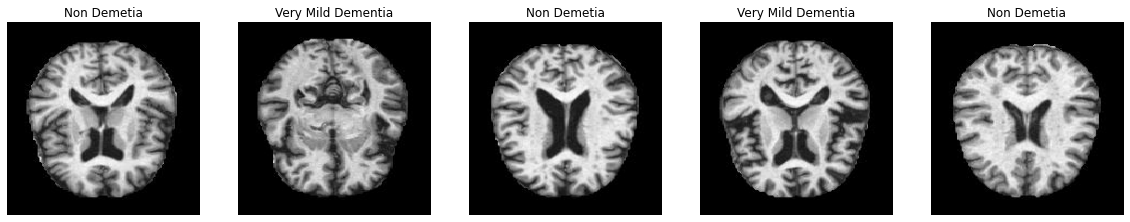

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [30]:
base_model = enet.EfficientNetB0(input_shape=(208,208,3), 
                                 include_top=False,
                                 weights="imagenet")

In [31]:
for layer in base_model.layers:
    layer.trainable=False

In [32]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [34]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.SGD(lr=0.01)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [35]:
filepath = './model_tuning208_128_SGD1e2.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [36]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.5423 - auc: 0.6274
Epoch 00001: val_auc improved from -inf to 0.63927, saving model to .\model_tuning208_128_SGD1e2.h5
65/65 [==============================] - 139s 2s/step - loss: 1.5423 - auc: 0.6274 - val_loss: 1.2930 - val_auc: 0.6393
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 1.2422 - auc: 0.7393
Epoch 00002: val_auc improved from 0.63927 to 0.66080, saving model to .\model_tuning208_128_SGD1e2.h5
65/65 [==============================] - 139s 2s/step - loss: 1.2422 - auc: 0.7393 - val_loss: 1.2787 - val_auc: 0.6608
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 1.1282 - auc: 0.7802
Epoch 00003: val_auc did not improve from 0.66080
65/65 [==============================] - 138s 2s/step - loss: 1.1282 - auc: 0.7802 - val_loss: 1.2597 - val_auc: 0.6591
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 1.0599 - auc: 0.8022
Epoch 00004: val_auc improv

65/65 [==============================] - 150s 2s/step - loss: 0.7798 - auc: 0.8890 - val_loss: 1.0462 - val_auc: 0.7763
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.7889 - auc: 0.8870
Epoch 00030: val_auc did not improve from 0.77626
65/65 [==============================] - 154s 2s/step - loss: 0.7889 - auc: 0.8870 - val_loss: 1.0526 - val_auc: 0.7755
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.7797 - auc: 0.8898
Epoch 00031: val_auc did not improve from 0.77626
65/65 [==============================] - 153s 2s/step - loss: 0.7797 - auc: 0.8898 - val_loss: 1.0568 - val_auc: 0.7745
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.7717 - auc: 0.8918
Epoch 00032: val_auc did not improve from 0.77626
65/65 [==============================] - 147s 2s/step - loss: 0.7717 - auc: 0.8918 - val_loss: 1.0600 - val_auc: 0.7731
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.7686 - auc: 0.8921
Epoch 

Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.6886 - auc: 0.9152
Epoch 00060: val_auc improved from 0.79625 to 0.79815, saving model to .\model_tuning208_128_SGD1e2.h5
65/65 [==============================] - 145s 2s/step - loss: 0.6886 - auc: 0.9152 - val_loss: 1.0337 - val_auc: 0.7981
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.6803 - auc: 0.9170
Epoch 00061: val_auc improved from 0.79815 to 0.81227, saving model to .\model_tuning208_128_SGD1e2.h5
65/65 [==============================] - 144s 2s/step - loss: 0.6803 - auc: 0.9170 - val_loss: 0.9876 - val_auc: 0.8123
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.6851 - auc: 0.9154
Epoch 00062: val_auc did not improve from 0.81227
65/65 [==============================] - 145s 2s/step - loss: 0.6851 - auc: 0.9154 - val_loss: 1.0307 - val_auc: 0.7982
Epoch 63/100
65/65 [==============================] - ETA: 0s - loss: 0.6765 - auc: 0.9181
Epoch 00063: val_auc

Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.6692 - auc: 0.9197
Epoch 00091: val_auc did not improve from 0.81227
65/65 [==============================] - 145s 2s/step - loss: 0.6692 - auc: 0.9197 - val_loss: 1.0008 - val_auc: 0.8112
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.6606 - auc: 0.9221
Epoch 00092: val_auc did not improve from 0.81227
65/65 [==============================] - 145s 2s/step - loss: 0.6606 - auc: 0.9221 - val_loss: 1.0042 - val_auc: 0.8106
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.6582 - auc: 0.9226
Epoch 00093: val_auc improved from 0.81227 to 0.81340, saving model to .\model_tuning208_128_SGD1e2.h5
65/65 [==============================] - 145s 2s/step - loss: 0.6582 - auc: 0.9226 - val_loss: 0.9881 - val_auc: 0.8134
Epoch 94/100
65/65 [==============================] - ETA: 0s - loss: 0.6470 - auc: 0.9251
Epoch 00094: val_auc improved from 0.81340 to 0.81353, saving model to .\

In [37]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 208, 208, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 104, 104, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 104, 104, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 104, 104, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

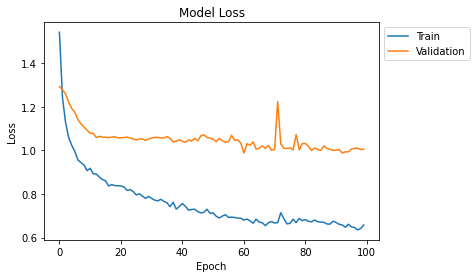

In [47]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

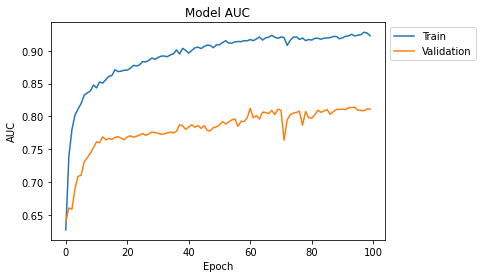

In [48]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

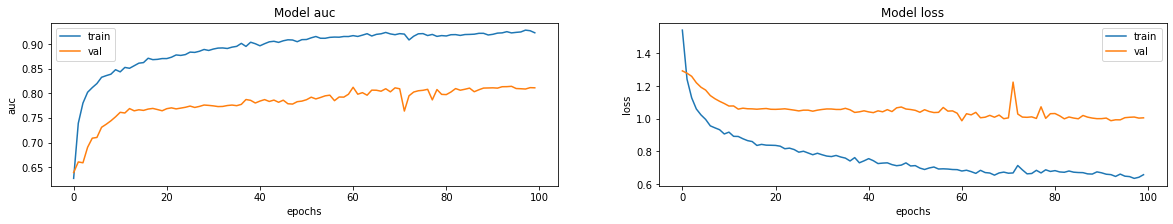

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (208,208),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [42]:
model.evaluate(test_dataset)

20/20 [==============================] - 33s 2s/step - loss: 0.7701 - auc: 0.8960


[0.7700842618942261, 0.8960141539573669]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
67.48 % chances are there that the image is NonDemented


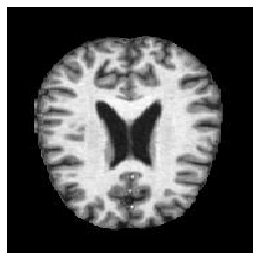

In [43]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

45.3 % chances are there that the image is MildDemented


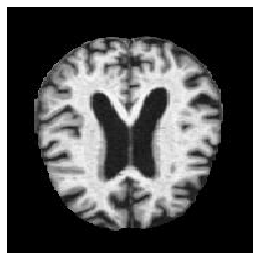

In [44]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

53.38 % chances are there that the image is MildDemented


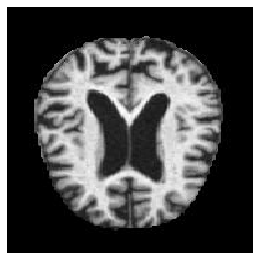

In [45]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

54.31 % chances are there that the image is VeryMildDemented


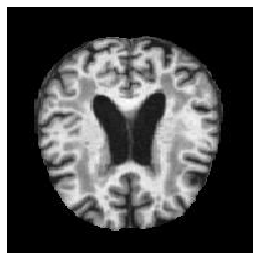

In [46]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])